In [10]:
import numpy as np
from matplotlib import pyplot as plt
# ----- Cord for importing .ipynb file as module -----
import sys  
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
# ----------------------------------------------------
from activations import *
from optimizer import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


class rnn_module:
    def __init__(self, layers_dims, init_range):
        self.params = {}
        self.grads = {}
        self.outputs = {}
        self.ld = layers_dims
        self.L = len(layers_dims)
        # Parameters of hidden layers
        for l in range(1, self.L-1):
            U = np.random.uniform(
                low = - init_weight_range,
                high = init_weight_range,
                size = (layers_dims[l-1], layers_dims[l])
            )
            W = np.random.uniform(
                low = - init_weight_range,
                high = init_weight_range,
                size = (layers_dims[l], layers_dims[l])
            )
            b = np.zeros((1, layers_dims[l]))
            self.params['U' + str(l)] = U         # Weights of H_lprev
            self.params['W' + str(l)] = W         # Weights of H_tprev
            self.params['b' + str(l)] = b         # Biases of hidden layers
        # Parameters of output layers
        V = np.random.uniform(
            low = - init_weight_range,
            high = init_weight_range,
            size = (layers_dims[self.L-2], layers_dims[self.L-1])
        )
        c = np.zeros((1, layers_dims[self.L-1]))
        self.params['V'] = V                      # Weights of output layer
        self.params['c'] = c                      # Biases of output layer
        self.params['U' + str(self.L-1)] = V
            
    def forward_propagate(self, X, activations):
        f = activations['hidden_activation']
        g = activations['output_activation']
        self.N = X.shape[0]
        self.T = X.shape[1]
        # Initialising hidden output
        for l in range(1, self.L-1):
            self.outputs['H' + str(l) + str(self.T)] = np.zeros((self.N, self.ld[l]))
        
        for t in reversed(range(self.T)):
            # Input Layer
            self.outputs['H0' + str(t)] = X[:, t, :]
            # Hidden Layers
            for l in range(1, self.L-1):
                U = self.params['U' + str(l)]
                W = self.params['W' + str(l)]
                b = self.params['b' + str(l)]
                H_lprev = self.outputs['H' + str(l-1) + str(t)]
                H_tprev = self.outputs['H' + str(l) + str(t+1)]
                Z = np.dot(H_lprev, U) + np.dot(H_tprev, W) + b
                H = f(Z)
                self.outputs['Z' + str(l) + str(t)] = Z
                self.outputs['H' + str(l) + str(t)] = H
            # Output Layer
            V = self.params['V']
            c = self.params['c']
            Z = np.dot(H, V) + c
            A = g(Z)
            self.outputs['Z' + str(self.L-1) + str(t)] = Z
            self.outputs['A' + str(t)] = A
        self.params['U' + str(self.L-1)] = V
        self.grads['U' + str(self.L-1)] = np.zeros_like(V)
        
    def compute_loss(self, Y):
        A = self.outputs['A0']
        # ==============================================================
        # Mean square error
        loss = np.sum(np.square(A - Y)) / self.N
        
        # Cross entoropy loss
#         loss = - np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m
        loss = np.squeeze(loss)
        # ==============================================================
        # --------------------------------------------------------------
        assert(loss.shape == ())
        # --------------------------------------------------------------
        return loss
    
    def back_propagate(self, Y, activations):
        df = activations['derivative_hidden_activation']
        dg = activations['derivative_output_activation']
        # Output Layer
        A = self.outputs['A0']
        Z = self.outputs['Z' + str(self.L-1) + '0']
        H_prev = self.outputs['H' + str(self.L-2) + '0']
        # ==============================================================
        # Mean square error
        dA = (A - Y) / self.N
        # Cross entropy loss
#         dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A)) / self.N
        # ==============================================================
        dZ_th_layer = dA * dg(Z)
        dV = np.dot(H_prev.T, dZ_th_layer)
        dc = np.sum(dZ_th_layer, axis = 0, keepdims = True)
        # --------------------------------------------------------------
        assert(dV.shape == self.params['V'].shape)
        assert(dc.shape == self.params['c'].shape)
        # --------------------------------------------------------------
        self.grads['V'] = dV
        self.grads['c'] = dc

        # Hidden Layers
        for l in reversed(range(1, self.L-1)):
            dU = np.zeros(self.params['U' + str(l)].shape)
            dW = np.zeros(self.params['W' + str(l)].shape)
            db = np.zeros(self.params['b' + str(l)].shape)
            U_next = self.params['U' + str(l+1)]
            W = self.params['W' + str(l)]
            # t = t
            H_tprev = self.outputs['H' + str(l) + '1']
            H_lprev = self.outputs['H' + str(l-1) + '0']
            Z = self.outputs['Z' + str(l) + '0']
            dH = np.dot(dZ_th_layer, U_next.T)
            dZ_th_layer = dH * df(Z)
            
            dU += np.dot(H_lprev.T, dZ_th_layer)
            dW += np.dot(H_tprev.T, dZ_th_layer)
            db += np.sum(dZ_th_layer, axis = 0, keepdims = True)
            dZ_th_time = dZ_th_layer
            # t = t-1 ~ t-T
            for t in range(1, self.T-1):
                Z = self.outputs['Z' + str(l) + str(t)]
                H_tprev = self.outputs['H' + str(l) + str(t+1)]
                H_lprev = self.outputs['H' + str(l-1) + str(t)]
                dH = np.dot(dZ_th_time, W)
                dZ_th_time = dH * df(Z)
                dU += np.dot(H_lprev.T, dZ_th_time)
                dW += np.dot(H_tprev.T, dZ_th_time)
                db += np.sum(dZ_th_time, axis = 0, keepdims = True)
            # ----------------------------------------------------------
            assert(dW.shape == self.params['W' + str(l)].shape)
            assert(db.shape == self.params['b' + str(l)].shape)
            # ----------------------------------------------------------
            self.grads['U' + str(l)] = dU
            self.grads['W' + str(l)] = dW
            self.grads['b' + str(l)] = db

    def test_rnn(self, X, activations):
        f = activations['hidden_activation']
        g = activations['output_activation']
        self.N = X.shape[0]
        self.T = X.shape[1]
        # Initialising hidden output
        for l in range(1, self.L-1):
            self.outputs['H' + str(l) + str(self.T)] = np.zeros((self.N, self.ld[l]))
        
        for t in reversed(range(self.T)):
            # Input Layer
            self.outputs['H0' + str(t)] = X[:, t, :]
            # Hidden Layers
            for l in range(1, self.L-1):
                U = self.params['U' + str(l)]
                W = self.params['W' + str(l)]
                b = self.params['b' + str(l)]
                H_lprev = self.outputs['H' + str(l-1) + str(t)]
                H_tprev = self.outputs['H' + str(l) + str(t+1)]
                Z = np.dot(H_lprev, U) + np.dot(H_tprev, W) + b
                H = f(Z)
                self.outputs['H' + str(l) + str(t)] = H
            # Output Layer
            V = self.params['V']
            c = self.params['c']
            Z = np.dot(H, V) + c
            A = g(Z)
        return A

Epoch: 1   Train Loss: 0.4419   Test Loss: 0.4690
Epoch: 100   Train Loss: 0.0016   Test Loss: 0.0021
Epoch: 200   Train Loss: 0.0009   Test Loss: 0.0017
Epoch: 300   Train Loss: 0.0011   Test Loss: 0.0015
Epoch: 400   Train Loss: 0.0013   Test Loss: 0.0015
Epoch: 500   Train Loss: 0.0010   Test Loss: 0.0023
Epoch: 600   Train Loss: 0.0009   Test Loss: 0.0014
Epoch: 700   Train Loss: 0.0009   Test Loss: 0.0017
Epoch: 800   Train Loss: 0.0011   Test Loss: 0.0016
Epoch: 900   Train Loss: 0.0010   Test Loss: 0.0016
Epoch: 1000   Train Loss: 0.0012   Test Loss: 0.0027


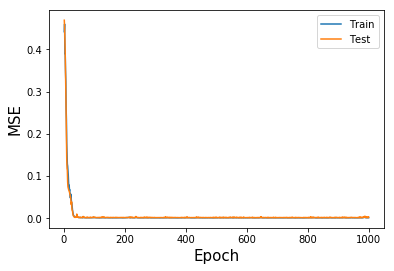

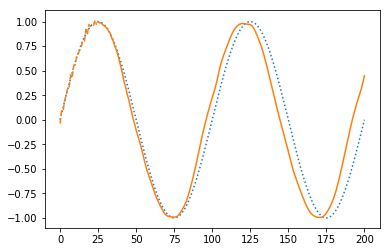

In [19]:
# -------------------< Toy Problem(Predict sin wave) >-------------------
if  __name__ == '__main__':
    def toy_problem(T = 100, A = 0.05):
        x = np.arange(0, 2 * T + 1)
        noise = A * np.random.uniform(low = - 1.0, high = 1.0, size = len(x))
        return np.sin(2.0 * np.pi * x / T) + noise
    
    # Prepare sin wave data
    T = 100
    f = toy_problem(T)
    seq_len = 25
    data = []
    target = []
    for t in range(2 * T - seq_len + 1):
        data.append(f[t: t + seq_len])
        target.append(f[t + seq_len])
    
    # Set up networks
    layer_dims = [1, 20, 20, 1] # <- Learning will success
#     layer_dims = [1, 20, 1]     # <- Learning will fail
    init_weight_range = 0.3
    rnn = rnn_module(layer_dims, init_weight_range)
    activations = return_activations(name_haf = 'tanh', name_oaf = 'linear')
    lr = 0.1
#     optimizer = SGD(rnn, lr)
    optimizer = Adam(rnn)

    # Create train and teach data
    X = np.array(data).reshape(len(data), seq_len, layer_dims[0])
    Y = np.array(target).reshape(len(target), layer_dims[-1])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    
    # Learning data
    epoches = 1000
    batch_size = 32
    Loss_train = []
    Loss_test = []
    n_batches = len(X_train) // batch_size
    for epoch in range(1, epoches + 1):
        loss_list = []
        X_train, Y_train = shuffle(X_train, Y_train)
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            rnn.forward_propagate(X_train[start:end], activations)
            loss_list.append(rnn.compute_loss(Y_train[start:end]))
            rnn.back_propagate(Y_train[start:end], activations)
            optimizer.update_params()
        Loss_train.append(np.mean(loss_list))
        rnn.forward_propagate(X_test, activations)
        Loss_test.append(rnn.compute_loss(Y_test))
        if epoch % 100 == 0 or epoch == 1:
            print('Epoch:', epoch,
                  '  Train Loss:', '{:.4f}'.format(Loss_train[-1]),
                  '  Test Loss:', '{:.4f}'.format(Loss_test[-1])
                 )
    
    # Plot Learning Curve
    plt.figure()
    plt.plot(np.arange(epoches) + 1, Loss_train, label='Train')
    plt.plot(np.arange(epoches) + 1, Loss_test, label='Test')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('MSE', fontsize=15)
    plt.legend()
    
    # Plot predicted sin wave
    Z = X[:1]
    original = [f[t] for t in range(seq_len)]
    predicted = [None for t in range(seq_len)]
    for t in range(2 * T - seq_len + 1):
        z = Z[-1:]
        y_pred = rnn.test_rnn(z, activations)
        sequence = np.concatenate(
            (z.reshape(seq_len, layer_dims[0])[1:], y_pred)
        ).reshape(1, seq_len, layer_dims[0])
        Z = np.append(Z, sequence, axis=0)
        predicted.append(float(y_pred))
    plt.figure()
    plt.plot(toy_problem(T, A=0), linestyle='dotted', color='tab:blue')
    plt.plot(original, linestyle='dashed', color='tab:orange')
    plt.plot(predicted, color='tab:orange')